## TME 7 Chaine de Markov Cach√©
### Annotation de g√®nes par cha√Ænes de Markov Cach√©

Les modeles de chaines de Markov cach√© sont tres utilis√©es notament dans les domaines de la reconnaisance de la parole, du traitement automatique du langage naturel, de la reconnaissance de l'√©criture manuscrite et de la bioinformatique.

Les 3 probl√®mes de bases des HMM (*Hidden Markov Model*) sont :
1. √âvaluation : 
 -  Probl√®me : calculer la probabilit√© d‚Äôobservation de la s√©quence d‚Äôobservations √©tant donn√©e un HMM:  
 -  Solution : *Forward Algorithm *

2. D√©codage : 
 - Probl√®me : trouver la s√©quence d‚Äô√©tats qui maximise la s√©quence d‚Äôobservations 
 - Solution : *Viterbi Algorithm *

3. Entra√Ænement :  
 - Probl√®me : ajuster les param√®tres du mod√®le HMM afin de maximiser la probabilit√© de g√©n√©rer une s√©quence d‚Äôobservations √† partir de donn√©es d‚Äôentra√Ænement  
  - Solution : *Forward-Backward Algorithm*
  

Dans ce TME, nous allons appliquer l'algorithme Viterbi √† des donn√©es biologiques.

# Rappel de biologie

Dans ce TME, nous allons voir comment les mod√®les statistiques peuvent √™tre utilis√©s pour extraire de l'information des donn√©es biologiques brutes. Le but sera de sp√©cifier des mod√®les de Markov cach√©es qui permettent d'annoter les positions des g√®nes dans le g√©nome.

Le g√©nome, support de l'information g√©n√©tique, peut √™tre vu comme une longue s√©quence de caract√®res √©crite dans un alphabet √† 4 lettres: A , C , G et T . Chaque lettre du g√©nome est aussi appel√©e pair de base (ou bp). Il est maintenant relativement peu co√ªteux de s√©quencer un g√©nome (quelques milliers d'euros pour un g√©nome humain). Cependant on ne peut pas comprendre, simplement √† partir de la suite de lettres, comment cette information est utilis√©e par la cellule (un peu comme avoir √† disposition un manuel d'instructions √©crit dans une langue inconnue).

Un √©l√©ment essentiel est le g√®ne, qui apr√®s transcription et traduction produira les prot√©ines, les mol√©cules responsables de la grande partie de l'activit√© biochimique des cellules.

La traduction en prot√©ine est faite √† l'aide du code g√©n√©tique qui, √† chaque groupe de 3 lettres (ou bp) transcrites fait correspondre un acide amin√©. Ces groupes de 3 lettres sont appel√©s codon et il y en a $4^3$, soit $64$. Donc, en premi√®re approximation, un g√®ne est d√©fini par les propri√©t√©s suivantes (pour les organismes procaryotes):

- Le premier codon, appel√© codon start est ATG,
- Il y a 61 codons qui codent pour la s√©quence d'acides amin√©s.
- Le dernier codon, appel√© codon stop, marque la fin du g√®ne et est l'une des trois s√©quences TAA , TAG ou TGA . Il n'appara√Æt pas dans le g√®ne. 


Nous allons int√©grer ces diff√©rents √©l√©ments d'information pour pr√©dire les positions des g√®nes. Notez que pour simplifier nous avons omis le fait que la mol√©cule d'ADN est constitu√©e de deux brins compl√©mentaires, et donc que les g√®nes pr√©sents sur le brin compl√©mentaire sont vus "√† l'envers" sur notre s√©quence. Les r√©gions entre les g√®nes sont appel√©es les r√©gions interg√©niques .

![Image of Yaktocat](https://cdn.kastatic.org/ka-perseus-images/1ade7bbd40ca8dbc7a55ddf4067935e42c347f35.png)

Chacune des s√©quences de g√®nes commence par un codon start et fini par un des codons stop. 

# Mod√©lisation de g√®nes 
## Question 1 : T√©l√©chargement des donn√©es

Nous travaillerons sur le premier million de bp du g√©nome de E. coli (souche 042). Plut√¥t que de travailler avec les lettres A , C , G et T , nous allons les recoder avec des num√©ros ($A =0$, $C=1$, $G=2$, $T =3$). 

Les annotations fournies sont √©galement cod√©es de $0$ √† $3$ :
- 0 si la position est dans une region non codante = region intergenique
- 1 si la position correspond a la position 0 d'un codon
- 2 si la position correspond a la position 1 d'un codon
- 3 si la position correspond a la position 2 d'un codon

In [38]:
# Telechargez le fichier et ouvrez le avec pickle
import numpy as np
import pickle as pkl

Genome=np.load('genome.npy') # Le premier million de bp de E. coli
Annotation=np.load('annotation.npy')# L'annotation sur le genome

## On divise nos donnees, la moitie va nous sevir pour l'apprentissage du mod√®le
## l'autre partie pour son evaluation

genome_train=Genome[:500000]
genome_test=Genome[500000:]

annotation_train=Annotation[:500000]
annotation_test=Annotation[500000:]


## Question 2 : Apprentissage 

Comme mod√®le le plus simple pour s√©parer les s√©quences de codons des s√©quences interg√©niques, on va d√©finir la cha√Æne de Markov cach√© dont le graphe de transition est donn√© ci dessous. 

![Image of Yaktocat](http://mapsi.lip6.fr/uploads/Cours/modele1.png)

Un tel mod√®le se d√©fini de la mani√®re suivante : nous considerons qu'il existe 4 √©tats cach√©s possibles (interg√©nique, condon 0, codon 1, condon 2).

On peut rester dans les r√©gions interg√©niques, et quand on d√©marre un g√®ne, la composition de chaque base du codon est diff√©rente. Il va falloir, afin de pouvoir utiliser ce mod√®le pour classifier, conna√Ætre les param√®tres pour la matrice de transition (donc ici uniquement les probas $a$ et $b$), et les lois $(b_i,i=0,‚Ä¶,3)$ des observations pour les quatre √©tats.

```python
Pi = np.array([1, 0, 0, 0])  ##on commence dans l'intergenique
A =  np.array([[1-a, a  , 0, 0], 
              [0  , 0  , 1, 0],
              [0  , 0  , 0, 1],
              [b  , 1-b, 0, 0 ]])
B = ...

```


√âtant donn√©e la structure d'un HMM (Hidden Markov Chain):

- les observations n'influencent pas les √©tats: les matrices $\Pi$ (distribution de probabilit√© initiale), $A$ (matrice de transition) s'obtiennent comme dans un mod√®le de Markov simple (cf semaine 6)
- chaque observation ne d√©pend que de l'√©tat courant 

La nature des donn√©es nous pousse √† consid√©rer des lois de probabilit√©s discr√®tes quelconques pour les √©missions. L'id√©e est donc de proc√©der par comptage en d√©finissant la matrice $B$ (matrice de probabilit√©s des √©missions) comme suit:

- $K$ colonnes (nombre d'observations), $N$ lignes (nombre d'√©tats)
- Chaque ligne correspond √† une loi d'√©mission pour un √©tat (ie, chaque ligne somme √† 1) 

Ce qui donne l'algorithme:

1. $b_{ij}$ = comptage des √©missions depuis l'√©tat $s_i$ vers l'observation $x_j$
2. normalisation des lignes de $B$ 

Donner le code de la fonction `def learnHMM(allX, allS, N, K):` qui apprend un mod√®le √† partir d'un ensemble de couples (seq. d'observations, seq. d'√©tats) 

In [39]:
def learnHMM(allx, allq, N, K):
    """ apprend un mod√®le √† partir 
    d'un ensemble de couples (seq. d'observations, seq. d'√©tats) 
    retourne les matrices A  B """
    A = np.zeros((N, N)) 
    B = np.zeros((N, K)) 
    # allx = un g√©nome = observation
    # allq = annotation = √©tats
    print(allx.shape)
    print(allq.shape)
    print(allq)
    for i in range(allx.shape[0]):
        B[allq[i], allx[i]]+=1
    for i in range( allq.shape[0]-1):
        A[allq[i], allq[i+1]]+=1
    #normaliser
    B/=np.maximum(B.sum(1).reshape(N,1), 1)
    A/=np.maximum(A.sum(1).reshape(N,1), 1)
    ### votre code
    return A, B
    pass

In [40]:
Pi = np.array([1, 0, 0, 0])
nb_etat= 4 ## (interg√©nique, condon 0, codon 1, condon 2)
nb_observation = 4 ## (A,T,C,G)
A,B =learnHMM(genome_train, annotation_train, nb_etat, nb_observation)
print(A)
print(B)

(500000,)
(500000,)
[0 0 0 ... 0 0 0]
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]


Vous devez trouver 

$A= $
```python
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
```
$B=$       
```python
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]
```
        
Notez que ce sont des matrices de probabilites, la somme de chaque ligne donne 1.

## Question 3 :  Estimation la s√©quence d'√©tats par Viterbi

Il n'est pas toujours √©vident de trouver les r√©gions codante et non codante d'un genome. Nous souhaiterions annoter automatiquement le g√©nome, c'est-√†-dire retrouver **la s√©quence d'√©tats cach√©s la plus probable** ayant permis de g√©n√©rer la s√©quence d'observation.

### Rappels sur l'algorithme Viterbi (1967):

- Il sert √† estimer la s√©quence d'√©tats la plus probable √©tant donn√©s les observations et le mod√®le.
- Il peut servir √† approximer la probabilit√© de la s√©quence d'observation √©tant donn√© le mod√®le. 

1\. Initialisation (avec les indices √† 0 en python): 

$$\begin{array}{ccccccccc} \delta_{0} (i) &=& \log \pi_{i} +\log b_{i} (x_{0}) \\ \Psi_{0}(i) &=& -1 \end{array}$$
 Note: L'initialisation de $\Psi_0(i)$ √† $-1$ car $-1$ n'est pas utilis√© normalement (n'est pas un √©tat valide).
 
2\. R√©cursion: 

$$ \begin{array}{ccccccccc} \delta_{t} (j) &=&\displaystyle \left[\max_{i} \delta_{t-1}(i) + \log a_{ij}\right] + \log b_{j}(x_{t}) \\ \Psi_{t}(j) &=&\displaystyle \arg\max_{i\in [1,\ N]} \delta_{t-1} (i) + \log a_{ij} \end{array}$$

3\. Terminaison (indices √† {$T-1$} en python) 

$$ S^{\star} = \max_{i} \delta_{T-1}(i)$$

4\. Chemin $$\begin{array}{ccccccccc} s_{T-1}^{\star} & = &\displaystyle \arg\max_{i} \delta_{T-1}(i) \\ s_{t}^{\star} & = & \displaystyle \Psi_{t+1}(s_{t+1}^{\star}) \end{array}$$

L'estimation de $\log p(x_0^{T-1} | \lambda)$ est obtenue en cherchant la plus grande probabilit√© dans la derni√®re colonne de $\delta$. Donner le code de la m√©thode `viterbi(x,Pi,A,B):`

In [130]:
def viterbi(allx,Pi,A,B):
    """
    Parameters
    ----------
    allx : array (T,)
        Sequence d'observations.
    Pi: array, (K,)
        Distribution de probabilite initiale
    A : array (K, K)
        Matrice de transition
    B : array (K, M)
        Matrice d'emission matrix

    """
    ## initialisation
    psi = np.zeros((len(A), len(allx))) # A = N
    psi[:,0]= -1 #colonne 0 pour tous les √©tats
    delta = np.zeros((len(A), len(allx)))  # initialisation en dimension mais pas en contenu !
    # init pour chaque √©tat
    delta[:,0]=np.log(Pi)+ np.log(B[:,allx[0]])
    ## recursion ...  (votre code )

    for t in range(1,len(allx)):
        # je remplis tous les j d'un seul coup en vectorisant 
        # j correspond au num√©ro d'√©tat 
        # t correspond √† une rang d'observation parmi toute la s√©quence d'observations
        # delta= meilleur score pour un chemin au temps T se terminant √† l'√©tat j
        
        delta[:, t]=np.transpose(np.max(np.reshape(delta[:, t-1], (len(A),1))+ np.log(A[:,:]), axis=0))+np.log(B[:,allx[t]])
        psi[:, t]=np.transpose(np.argmax(np.reshape(delta[:,t-1], (len(A), 1))+np.log(A), axis=0))
       
    # parcourir √† l'envers pour trouver le chemin optimal
    # initialisation dans le chemin inverse
    T=(len(allx))
    S=np.zeros(allx.shape)
    # pour debuggage
    S[T-1]=np.argmax(delta[:,T-1 ])
    for i in range(T-2,-1, -1):
        #print(S[i+1])
        S[i]=psi[np.int(S[i+1]),i+1]
    return S
    pass
    

In [131]:
etat_predits=viterbi(genome_test,Pi,A,B)
print("√©tats pr√©dits")    
print(etat_predits)
print(" annotations donn√©es")
print(annotation_test)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


√©tats pr√©dits
[0. 0. 0. ... 1. 2. 3.]
 annotations donn√©es
[0 0 0 ... 0 0 0]


In [132]:
print(etat_predits==annotation_test)
print(np.sum(etat_predits1==annotation_test))
print ( np.sum(etat_predits==annotation_test))
print(np.sum(etat_predits))
print(len(etat_predits))

[ True  True  True ... False False False]
265721
180635
711036.0
500000


In [133]:
I=np.array([[1,2], [3, 4]])
print(np.max(I, axis=0))
S=np.array([[1],[2]])
print(S+I)

[3 4]
[[2 3]
 [5 6]]


In [134]:
I[:,0]=np.transpose(np.array([5,5]))
print(I)

[[5 2]
 [5 4]]


## Affichage
On met les √©tats cach√©s soit √† $0$ (**non codant**) soit √† $1$ (**codant**).
```python
etat_predits[etat_predits!=0]=1 
annotation_test[annotation_test!=0]=1
```
puis on affiche pour position du g√©nome si c'est une position codante ou non en utilisant les vrais annotations, puis on affiche pour chaque position si elle est predite comme codante ou non.
```python
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()
```

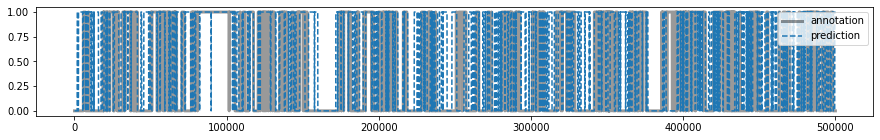

In [138]:
import matplotlib.pyplot as plt
etat_predits[etat_predits!=0]=1 
annotation_test[annotation_test!=0]=1

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()

Vous pouvez consid√©rer une sous partie du g√©nome, par exemple entre 100000 et 200000. Commentez vos observations sur la qualit√© de la pr√©diction.

## Question 4 :  Evaluation des performances

√Ä partir des pr√©dictions et des vrai annotations du g√©nome, dessiner la matrice de confusion. 

<div  align="left"><img src="confusion.png" width="200"></div>

Avec : 
- TP = True Positives, les r√©gions codantes correctement pr√©dictes,
- FP = False Positives, les r√©gions interg√©nique pr√©dites comme des r√©gions codantes,
- TN = True Negatives, les r√©gions intergeniques pr√©dites correctement,
- FN = False Negatives, les r√©gions codantes pr√©dites comme non codantes.

L'√©tat **non codant** est l'√©tat $0$, les autres ($1,2,3$) sont les √©tats **codants**.

![](conf2.png)


In [139]:
def create_confusion_matrix(true_sequence, predicted_sequence):
    ## votre code
    etat_predits[predicted_sequence!=0]=1
    #etat_predits[predicted_sequence==0]=1
    annotation_test[true_sequence!=0]=1
    #annotation_test[true_sequence==0]=1
    conf=np.zeros((2, 2))
    for i in range(len(etat_predits)):
        conf[1-np.int(etat_predits[i]), 1-np.int(annotation_test[i]) ]+=1
    return conf
    pass

Apr√®s avoir cr√©√© la matrice de confusion, vous pouvez l'afficher en utilisant :

```python

mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()
```

[[202819. 152699.]
 [ 31460. 113022.]]


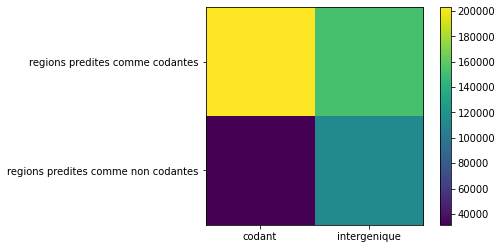

In [140]:
import matplotlib.pyplot as plt 

mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()

Donner une interpr√©tation.
Peut-on utiliser ce mod√®le pour pr√©dire la position des g√®nes dans le g√©nome ?

In [105]:
 TP,FP=mat_conf[0] 
 FN,TN=mat_conf[1] 

# on ne peut pas utiliser ce mod√®le pour pr√©dire les g√®nes dans le g√©nomes car le nombre de faux positifs est beaucoup trop grand
on veut que la pr√©cision et le recall soit grand pour dire qu'un mod√®le est bon

In [107]:
precision=TP/(TP+FP)
recall=TP/(TP+FN)
accuracy=(TP+TN)/len(annotation_test)
print(precision)
print(recall)
print(accuracy)

0.5704886953684483
0.8657156638025602
0.631682


### On observe bien que la pr√©cision n'est pas tr√®s bonne, elle est de 57%

## Question 5 :  G√©n√©ration de nouvelles s√©quences

En utilisant le mod√®le $ \lambda=\{Pi,A,B\}$, cr√©er ` create_seq(N,Pi,A,B) ` une fonction permettant de g√©n√©rer :
- une s√©quence d'√©tats cach√©s
- une sequence d'observations.

In [111]:
# on remet la fonction de tirage al√©atoire d'√©tats du tme pr√©c√©dent
import random
def tirage( sc):
    #somme cumul√©e
    cum_sum=sc.cumsum()
    val=random.random()
    i=0
    while(val>cum_sum[i]):
        i+=1
    return i

In [114]:
def create_seq(N,Pi,A,B):
    '''
    Produire N √©tats cach√©s en utilisant Pi et A
    
    et pour chaque √©tat cach√©s produire une observation en utilisant B
    '''
    ## votre code
    # S: s√©quence d'√©tats cach√©s
    S=np.zeros((N,1))
    # X sequence d'observations
    X=np.zeros((N,1))
    # on tire d'abord l'√©tat initial
    S[0]=tirage(Pi)
    for i in range(N):
        S[i]=tirage(A[np.int(S[0]),:])
        X[i]=tirage(B[np.int(S[i]),:])
    return S, X
    pass
    

In [116]:
S,X=create_seq(4,Pi,A,B)
print(S)
print(X)

[[0.]
 [0.]
 [0.]
 [0.]]
[[1.]
 [1.]
 [1.]
 [3.]]


## Question 6 : Construction d'un nouveau mod√®le

√âvaluons maintenant si cela s'am√©liore en prenant en compte les fronti√®res des g√®nes en construisant un mod√®le avec codon start et codon stop.
On veut maintenant d'int√©grer l'information compl√©mentaire qui dit qu'un g√®ne commence "toujours" par un codon start et finit "toujours" par un codon stop avec le graphe de transition ci-dessous.

On consid√®re donc maintenant un mod√®le √† 12 √©tats cach√©s.
![](modele2.png)


- √âcrivez la matrice de transition correspondante, en mettant les probabilit√©s de transition entre lettres pour les codons stop √† 0.5.


- Adaptez la matrice des √©missions pour tous les √©tats du mod√®le. Vous pouvez r√©utiliser la matrice B, calcul√©e pr√©c√©dement. Les √©tats correspondant au codons stop n'√©mettrons qu'une seule lettre avec une probabilit√© $1$.
Pour le codon start, on sait que les proportions sont les suivantes: 

    - ATG : 83%, 
    - GTG: 14%,     
    - TTG: 3%

```python
Pi2 = np.array(   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])  ##on commence encore dans l'intergenique
A2 =  np.array([[1-a, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                [0  , 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                  ... ])
B2 = ...

```


In [120]:
#A2
N=12
K=4
Pi2= np.array(   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])
A2=np.zeros((N,N))
A2[0,0]=A[0,0]
A2[0,1]=A[0,1]
A2[1, 2]=1 
A2[2,3]=1  
A2[3,4]=1
A2[4,5]=1
A2[5,6]=1
A2[6,4]=A[3,1]
A2[6,7]=A[3,0]
A2[7,8 ]=0.5
A2[7,9]=0.5
A2[8,10]=1
A2[9,10]=0.5
A2[9,11]=0.5
A2[10,0]=1
A2[11,0]=1

In [121]:
print(A2)

[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
[[0.99899016 0.00100984 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.

In [125]:
#B2
B2=np.zeros((N,K))
l=[0,4,5,6]
for i in l:
    B2[i,:]=B[l.index(i)]
B2[1,:]=np.array([0.83,0,0.14,0.3])
#ùê¥=0 , ùê∂=1, ùê∫=2, ùëá=3
B2[2,3]=1 #T
B2[3,2]=1 #G
B2[7,3]=1 #T
B2[8,2]=1 #G
B2[9,0]=1 #A
B2[10,0]=1 #A
B2[11,2]=1  #G
print(B2)

[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.83       0.         0.14       0.3       ]
 [0.         0.         0.         1.        ]
 [0.         0.         1.         0.        ]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]
 [0.         0.         0.         1.        ]
 [0.         0.         1.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         1.         0.        ]]


√âvaluez les performances du nouveau mod√®le en faisant de nouvelles predictions d'annotation pour genome_test, et comparez les avec le mod√®le pr√©c√©dent. 
```
etat_predits2=viterbi(genome_test,Pi2,A2,B2)
etat_predits2[etat_predits2!=0]=1 
```

```python

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction model1", ls="--")
ax.plot(etat_predits2, label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()
```

Calculer la matrice de confusion avec les nouvelles pr√©dictions.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


[-1.41273607        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf]
[-1.41273607        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf]


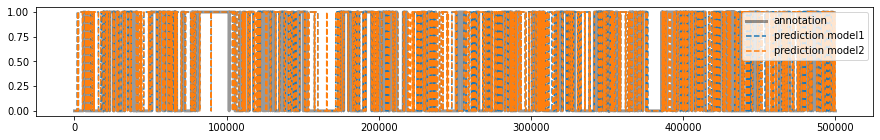

In [126]:
etat_predits2=viterbi(genome_test,Pi2,A2,B2)
etat_predits2[etat_predits2!=0]=1 

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction model1", ls="--")
ax.plot(etat_predits2, label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()

[[213870. 171994.]
 [ 20409.  93727.]]


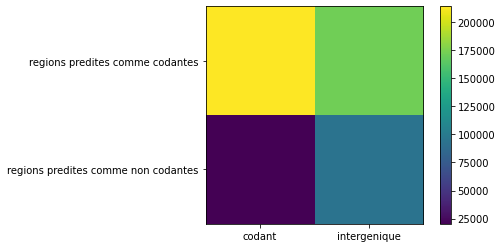

In [141]:
mat_conf=create_confusion_matrix(annotation_test, etat_predits2)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()